#自定义训练：基础知识
在上一个教程中，我们介绍了用于自动区分的TensorFlow API，这是机器学习的基本构建块。在本教程中，我们将使用先前教程中介绍的TensorFlow原语来进行一些简单的机器学习。

TensorFlow还包括一个更高级别的神经网络API（tf.keras），它提供了有用的抽象来减少样板。我们强烈建议那些使用神经网络的人使用更高级别的API。但是，在这个简短的教程中，我们从第一原理开始介绍神经网络训练，以建立坚实的基础。

##建立


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

tf.enable_eager_execution()

##变量
TensorFlow中的张量是不可变的无状态对象。然而，机器学习模型需要具有变化的状态：随着模型训练，计算预测的相同代码应该随着时间的推移而表现不同（希望具有较低的损失！）。要表示需要在计算过程中进行更改的状态，您可以选择依赖Python是一种有状态编程语言的事实：

In [10]:
#Using pythone state

x = tf.zeros([10,10])
x += 2 #This is equivalent to x = x +2 ,which does not mutate the original
       #value of x
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


但是，TensorFlow内置了有状态操作，这些操作通常比您所在州的低级Python表示更令人愉快。例如，为了表示模型​​中的权重，使用TensorFlow变量通常是方便有效的。

变量是一个存储值的对象，当在TensorFlow计算中使用时，它将隐式地从该存储值中读取。有些操作（`tf.assign_sub，tf.scatter_update`等）操纵存储在TensorFlow变量中的值。

In [0]:
v = tf.Variable(1.0)
assert v.numpy() == 1.0

#Re-assign the value
v.assign(3.0)
assert v.numpy() == 3.0

#Use 'v' in a TensorFlow operation like tf.square() and reassign
v.assign(tf.square(v))
assert v.numpy() == 9.0

计算梯度时会自动跟踪使用变量的计算。对于表示嵌入的变量，TensorFlow默认会进行稀疏更新，这样可以提高计算效率和内存效率。

使用变量也是一种快速让代码的读者知道这段状态是可变的方法。

##示例：拟合线性模型
现在，我们让我们有几个概念至今--- Tensor，GradientTape，Variable---建立和培养一个简单的模型。这通常涉及几个步骤：

1. 定义模型。
2. 定义损失函数。
3. 获取培训数据。
4. 运行训练数据并使用“优化器”调整变量以适合数据。

在本教程中，我们将介绍一个简单线性模型的简单示例：f(x) = x * W + b它有两个变量 - W和b。此外，我们将合成数据，以便训练有素的模型具有W = 3.0和b = 2.0。

##定义模型
让我们定义一个简单的类来封装变量和计算。

In [0]:
class Model(object):
  def __init__(self):
    #Initialize variable to (5.0,0.0)
    #In proctice, these should be initialized to random values.
    self.W = tf.Variable(5.0)
    self.b = tf.Variable(0.0)
    
  def __call__(self,x):
    return self.W * x + self.b
  
model = Model()

assert model(3.0).numpy() == 15.0

##定义损失函数
损失函数测量给定输入的模型输出与期望输出的匹配程度。让我们使用标准的L2损失。

In [0]:
def loss(predicted_y, desired_y):
  return tf.reduce_mean(tf.square(predicted_y - desired_y))

##获取培训数据
让我们用一些噪音合成训练数据。

In [0]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs = tf.random_normal(shape=[NUM_EXAMPLES])
noise = tf.random_normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

在我们训练模型之前，让我们可以看到模型现在所处的位置。我们将用红色绘制模型的预测，用蓝色绘制训练数据。

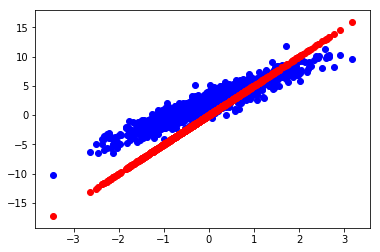

Current loss:
9.773733


In [15]:
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs,model(inputs), c='r')
plt.show()

print('Current loss:'),
print(loss(model(inputs), outputs).numpy())

##定义训练循环
我们现在拥有我们的网络和培训数据。让我们训练它，即使用训练数据来更新模型的变量（W和b），以便使用梯度下降来减少损失。在tf.train.Optimizer实现中捕获了许多梯度下降方案的变体。我们强烈建议使用这些实现，但本着从第一原则构建的精神，在这个特定的例子中，我们将自己实现基本的数学。

In [0]:
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
    
  dW, db = t.gradient(current_loss, [model.W, model.b])
  model.W.assign_sub(learning_rate * dW)
  model.b.assign_sub(learning_rate * db)

最后，让我们通过反复训练数据运行，看看W和b发展。

Epoch  0: W=5.00 b=0.00, loss=9.77373
Epoch  1: W=4.57 b=0.43, loss=6.47239
Epoch  2: W=4.24 b=0.77, loss=4.41741
Epoch  3: W=3.97 b=1.04, loss=3.13826
Epoch  4: W=3.76 b=1.25, loss=2.34203
Epoch  5: W=3.60 b=1.42, loss=1.84640
Epoch  6: W=3.47 b=1.55, loss=1.53789
Epoch  7: W=3.36 b=1.66, loss=1.34585
Epoch  8: W=3.28 b=1.74, loss=1.22632
Epoch  9: W=3.22 b=1.81, loss=1.15191


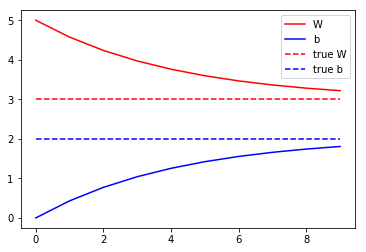

In [17]:
model = Model()

#Collect the history of W-values and b-values to plot later
Ws, bs = [],[]
epochs = range(10)
for epoch in epochs:
  Ws.append(model.W.numpy())
  bs.append(model.b.numpy())
  current_loss = loss(model(inputs), outputs)
  
  train(model, inputs, outputs, learning_rate = 0.1)
  print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
       (epoch, Ws[-1], bs[-1], current_loss))
  
#Let's plot it all
plt.plot(epochs, Ws, 'r',
        epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
        [TRUE_b] * len(epochs), 'b--')
plt.legend(['W','b', 'true W', 'true b'])
plt.show()

##下一步
在本教程中，我们介绍了Variables，并使用到目前为止讨论的TensorFlow原语构建并训练了一个简单的线性模型。

从理论上讲，这几乎是您使用TensorFlow进行机器学习研究所需要的全部内容。在实践中，特别是对于神经网络，更高级别的API tf.keras会更方便，因为它提供更高级别的构建块（称为“层”），保存和恢复状态的实用程序，一套损失函数，一套优化策略等等